## Getting started with Machine Learning for stock price prediction

In this notebook we want to show some basic principles and warn of some thorny issues.

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5, 3) # use bigger graphs

## Load the dataset
We load our preprocessed dataset as usual

In [2]:
input_file = '/data/cooked_v3.pkl'
df = pd.read_pickle(input_file)
df['CalcDateTime'] = df.index

## Generate a dataset with features

We generate a number of features we have found useful from prior experience.
Deliberately not all features have the same normalization because then they will be co-linear.
Alignment of shifted timeseries is tricky due to non-trading times

In [3]:
def closer_to_with_normalization(pnt, a, b, norm):
    return (np.absolute(pnt - a) - np.absolute(pnt - b))/norm

def resample_single_stock(single_stock, interval):
    df = pd.DataFrame({
        'MaxPrice': single_stock['MaxPrice'].resample(interval).max(),
        'MinPrice': single_stock['MinPrice'].resample(interval).min(),
        'LastEndPrice': single_stock['EndPrice'].resample(interval).last(),
        'FirstStartPrice': single_stock['StartPrice'].resample(interval).first(),         
        'MeanEndPrice': single_stock['EndPrice'].resample(interval).mean(),        
        'HasTrade': single_stock['HasTrade'].resample(interval).max(),
    })
    # Warning: this works because we had forward filled the prices
    df = df[df['HasTrade'] == 1.0]
    return df

def rev_pct_change(a, t):
    one_step_in_past = a
    t_steps_in_past = a.shift(1).ffill()
    return ((one_step_in_past - t_steps_in_past)/one_step_in_past).fillna(0.0)

def prepare_single_stock_multi_intervals(mnemonic, predicted_price, main_interval, intervals):
    single_stock = df[df.Mnemonic == mnemonic].copy()
        
    main = resample_single_stock(single_stock, main_interval)
    # we use the same anchor
    anchor = main['MeanEndPrice']
    future_mean_price = main[predicted_price].shift(-1)
    main['y:AdjustedPctChange[t + 1]'] = (future_mean_price - anchor)/anchor
    
    all_intervals = [main_interval] + intervals
    
    for interval in all_intervals:
        sub = resample_single_stock(single_stock, interval)
        resampled = sub.resample(main_interval).last() 

        main['x:Direction@' + interval] = \
            2.0*(resampled['LastEndPrice'] - resampled['FirstStartPrice'])/ \
            anchor

        main['x:SignDirection@' + interval] = np.sign(main['x:Direction@' + interval])
        
        main['x:D1@' + interval] = np.where( 
            (main['x:SignDirection@' + interval] == 1.0) &
            (main['x:SignDirection@' + interval].shift(1) == 1.0), 1.0, 0.0)
        
        main['x:D2@' + interval] = np.where( 
            (main['x:SignDirection@' + interval] == -1.0) &
            (main['x:SignDirection@' + interval].shift(1) == -1.0), -1.0, 0.0)        
        
        main['x:D@' + interval] = main['x:D1@' + interval] + main['x:D2@' + interval]
        main = main.drop(columns=[
            'x:SignDirection@' + interval,
            'x:D1@' + interval,
            'x:D2@' + interval
        ])
        main['x:H1@' + interval] = - closer_to_with_normalization(
                                                 resampled['LastEndPrice'], 
                                                 resampled['MaxPrice'], 
                                                 resampled['MinPrice'],
                                                 anchor)    
        
        main['x:EndToMean@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/anchor
        
        main['x:AdjustedPctChange@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/resampled['MeanEndPrice']
        main['x:RevPctChange@' + interval] = rev_pct_change(resampled['LastEndPrice'], 1)
    
    main = main[main['HasTrade'] == 1.0]
    meta = main[['MeanEndPrice', 'HasTrade', 'LastEndPrice']]
    main = main.drop(columns = [
        'MaxPrice',
        'MinPrice',
        'LastEndPrice',
        'FirstStartPrice',         
        'MeanEndPrice',     
        'HasTrade'       
    ])
    return main, meta

We predict daily movments. Uncomment the line below to predict hourly movements instead.

In [4]:
main_interval, intervals = '1D', ['12H']
# uncomment for hourly prediction
#main_inrerval, intervals = '60Min', ['15Min', '20Min', '30Min']

stock_id = 'BMW'

single_stock, meta = prepare_single_stock_multi_intervals(stock_id, 'MeanEndPrice', main_interval, intervals)

k = 'y:AdjustedPctChange[t + 1]'
sorted_features = single_stock.corr()[[k]].sort_values(k, ascending=False)
best_x = sorted_features.index[1]
sorted_features

,y:AdjustedPctChange[t + 1]
y:AdjustedPctChange[t + 1],1.000000
x:H1@1D,0.365771
x:EndToMean@1D,0.357924
x:AdjustedPctChange@1D,0.357924
x:RevPctChange@1D,0.280874
x:RevPctChange@12H,0.280874
x:Direction@12H,0.274948
x:D@1D,0.263379
x:Direction@1D,0.262270
x:H1@12H,0.251434


In [5]:
def make_inverter(m, s, th):
    return lambda y: y*s + m

def normalize_features(prepared_single_stock):
    th = 2.5  
    inp = prepared_single_stock.copy()
    inverters = {}
    for f in list(inp.dtypes.index):
        fn = inp[f]
        s = 0.0000001 + np.std(fn.values)
        m = np.mean(fn.values)
        norm = (fn-m)/s
        inverters[f] = make_inverter(m, s, th)
        inp[f] = np.where(norm > th, th, np.where(norm < -th, -th, norm))
    return inp, inverters

In [6]:
training_data, meta = prepare_single_stock_multi_intervals(stock_id, 'MeanEndPrice', main_interval, intervals)
training_data = training_data.dropna()
training_data, inverters = normalize_features(training_data)
y_feature = filter(lambda n: n.startswith("y:"), training_data.dtypes.index)[0]
x_features = filter(lambda n: n.startswith("x:"), training_data.dtypes.index)
X_train = training_data[x_features]
y_train = training_data[y_feature]

We train a linear model below and report the coefficients values. 
Some coefficients are negative, although all features have positive correlations.
This is normal since most of the features are mutually correlated.

In [7]:
model = Ridge(alpha=0.5)
# it seems that thresholding leads to more robust results,
# one can also try with logistic regression
thresholded_y = np.sign(y_train.values)
model.fit(X_train.values, thresholded_y)
coefs = pd.DataFrame(zip(x_features, model.coef_), columns=['Feature', 'Coef'])
coefs['AbsCoef'] = np.absolute(coefs['Coef'])
coefs.sort_values('AbsCoef', ascending=False)[['Feature', 'Coef']]

,Feature,Coef
2,x:H1@1D,0.618608
0,x:Direction@1D,-0.448251
1,x:D@1D,0.206603
8,x:H1@12H,0.183822
10,x:AdjustedPctChange@12H,-0.145037
9,x:EndToMean@12H,-0.131077
6,x:Direction@12H,-0.120457
5,x:RevPctChange@1D,0.077456
11,x:RevPctChange@12H,0.077456
4,x:AdjustedPctChange@1D,0.038724


In [8]:
predicted = model.predict(X_train.values)
predicted = pd.Series(predicted, y_train.index)
predicted.head()

CalcDateTime
2017-07-03   -0.134468
2017-07-04   -0.308544
2017-07-05   -0.481498
2017-07-06    0.208537
2017-07-07    0.488728
dtype: float64

In [9]:
meta['predicted'] = predicted
meta['y'] = y_train
meta['y[t - 1]'] = y_train.shift(1)
meta['strongest_x'] = training_data[best_x]

Compared to the strongest feature the model improved the correlation between the predicted and true vaues

In [10]:
meta[['y', 'y[t - 1]', 'predicted', 'strongest_x']].corr()[['y']].sort_values('y', ascending=False)

,y
y,1.000000
predicted,0.457225
strongest_x,0.380007
y[t - 1],0.199211


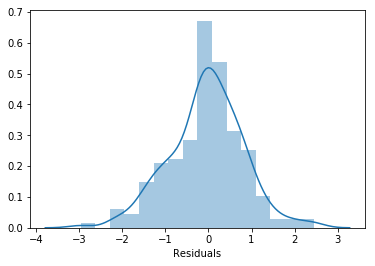

In [11]:
residuals = pd.Series((predicted - y_train).values, name="Residuals")
ax = sns.distplot(residuals)

In [12]:
def add_pred(name, pred):
    pred = inverters[y_feature](pred)
    
    meta['Restored:' + name] = (meta['MeanEndPrice'] * (pred + 1.0)).shift(1)

add_pred('y', y_train)
add_pred('y[t - 1]', y_train.shift(1)) 
add_pred('pred', predicted)

Notice that we don't predict the actual price, but percent return.
Having percent return and the previous price we can construct the next price.
This is what we show below. There are some discrepancies because we truncate the actual percent
returns to improve the stability of model fit.

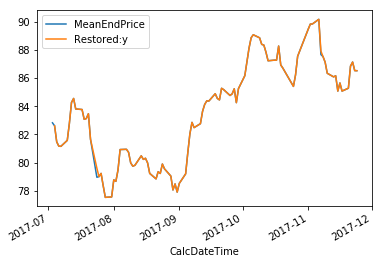

In [13]:
meta[['MeanEndPrice', 'Restored:y']].head(100).plot()

Next we plot our predictions (Restored:pred) and our baseline(Restored:y[t-1]).
Our baseline is simply the curve shifted, from the present, one step into the future.

As it can be observed the baseline is more noisy, so the model improved the fit.

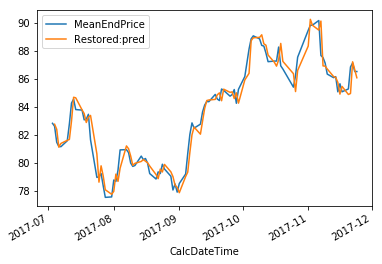

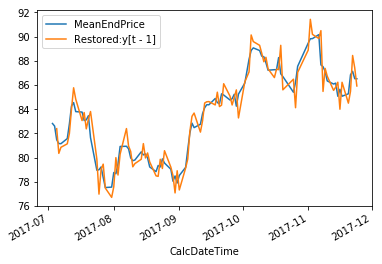

In [14]:
meta[['MeanEndPrice', 'Restored:pred']].head(100).plot()
meta[['MeanEndPrice', 'Restored:y[t - 1]']].head(100).plot()

Next we show the same three plots but over a smaller timescale, so one could better see the results of model fitting.

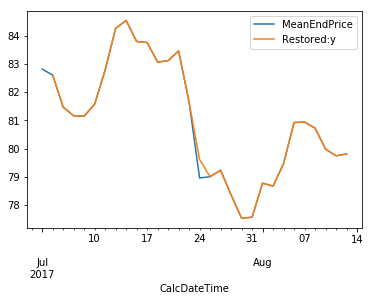

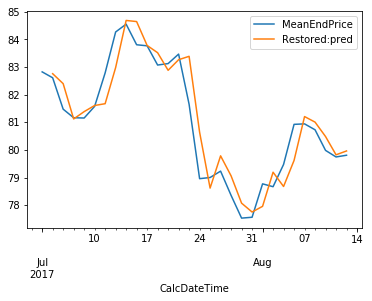

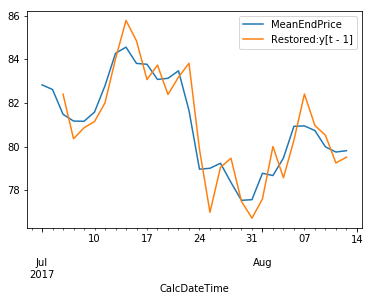

In [15]:
meta[['MeanEndPrice', 'Restored:y']].head(30).plot()
meta[['MeanEndPrice', 'Restored:pred']].head(30).plot()
meta[['MeanEndPrice', 'Restored:y[t - 1]']].head(30).plot()

In [16]:
meta[['MeanEndPrice', 'Restored:y', 'Restored:pred', 'Restored:y[t - 1]']].corr()[['MeanEndPrice']]

,MeanEndPrice
MeanEndPrice,1.000000
Restored:y,0.999807
Restored:pred,0.980445
Restored:y[t - 1],0.965024


In [17]:
def agreement(a, b):
    agree = np.where(np.sign(a)*np.sign(b) == 1.0, 1.0, 0.0).sum()
    n = a.shape[0]
    return 100.0*agree/n
model = agreement(meta['y'], meta['predicted'])
baseline = agreement(meta['y'], meta['y[t - 1]'])
print """Model agrees with actual AVERAGE market movement in {} percent,
while baseline agrees with AVERAGE market movement in {} percent.
(Note: on the training set)
""".format(model, baseline)

Model agrees with actual AVERAGE market movement in 68.8442211055 percent,
while baseline agrees with AVERAGE market movement in 52.2613065327 percent.
(Note: on the training set)



## Observed Challenges

### Data alignment
The challenges here lie with aligning the data. Shifting operations, forward filling, dealing with nans are potentially error prone. One needs to put a lot of effort into testing those edge cases. For example, there are many minutes and days without trades.
From financial perspective, beginnings, ends of days and Monday, and Fridays should be treated differently.
Another challenge is creating features at different frequencies as one needs to be aware of trading hours.

### Evaluation or error measurment

Here we have taken a simple strategy to measure correlations and agreement in the prediction of the directions.

### Error analysis

When the model makes errors, does that signal a change of trend or is simply noise.
We could analyze the cases with errors and look for extra features.
ROC curves would be helpful, as well as running the model predictions with different strategies

### Feature Selection

A lot of our features are correlated. This is normal since they derive from 3 underlying signals: EndPrice, MinPrice, MaxPrice

In general this does mean we should drop them and keep the most important onces, although we could.
For example, in image recognition a lot of raw features (image pixels) are "locally correlated", but people
have found a way to make most of those correlations

### Non-linear models

Instead of relying on putting non-linearity in our features we can consider non-linear models such as decision trees and neural nets.

A lot of practitioners in the stock market technical analysis rely on heuristics that are non-linear in nature
to stop a change of trend. For example, crossing points between lines connecting last local minimums and maximums,
or counting a number of consequtive down and up movements.

### Abstraction

Once we are done with data exploration, it is clear that one needs solid software engineering to create a proper data transformation pipeline. We want our feature generation, data alignment, model fitting and model predictions to be first class citizens.
If we are able to abstract the model, we could run it over multiple intervals, say 1 day, 2 days and so on,
and build more complex models on top.